In [2]:
import torch.nn.functional as F
from utilities3 import *
from timeit import default_timer

import numpy as np
import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torchinfo import summary
import sys
import netCDF4 as nc
from data_loader_SSH import load_test_data, load_test_data_DTAS
from data_loader_SSH import load_train_data, load_train_data_DTAS
from count_trainable_params import count_parameters
import hdf5storage

2.0.1+cu117
2.0.1+cu117


In [3]:
import matplotlib.pyplot as plt
import pandas as pd


In [4]:
datastore_filepath = '/data/NASA_DTAS_datastore/'
filename_dict = {
    'u10' : 'U10_large_domain/U10deg_025',
    'v10' : 'V10_large_domain/V10deg_025',
    't2m' : 'T2m_large_domain/T2mdeg_025',
    'mslhf' : 'MSLHF_large_domain/MSLHFdeg_025',
    'msshf' : 'MSSHF_large_domain/MSSHFdeg_025'
}

def get_testdata(yr, vlist, lead):
    """
    high-level wrapper to extract input/label data in torch format from nc file for multiple variables
    --------------------------
    arg: year, list of variables to extract, lead no. of timestep
    
    """
    input_array_torch = torch.zeros((2,2,2,2))
    label_array_torch = torch.zeros((2,2,2,2))
    grid_size = 0

    for i,v in enumerate(vlist):
        DS = nc.Dataset(datastore_filepath + filename_dict[v] + str(yr) + '.nc')
        if i == 0:
            input_array_torch, label_array_torch, grid_size  = load_test_data_DTAS(DS, lead, v)
        else:
            input_torch, label_torch, _ = load_test_data_DTAS(DS, lead, v)
            input_array_torch = torch.concatenate((input_array_torch, input_torch), axis=1)
            label_array_torch = torch.concatenate((label_array_torch, label_torch), axis=1)
            
    return input_array_torch, label_array_torch, grid_size

def get_traindata(yr, vlist, lead, trainN):
    """
    high-level wrapper to extract input/label data in torch format from nc file for multiple variables
    --------------------------
    arg: year, list of variables to extract, lead no. of timestep
    
    """
    input_array_torch = torch.zeros((2,2,2,2))
    label_array_torch = torch.zeros((2,2,2,2))
    grid_size = 0

    for i,v in enumerate(vlist):
        # print("dMsg:", i, v)
        DS = nc.Dataset(datastore_filepath + filename_dict[v] + str(yr) + '.nc')
        if i == 0:
            input_array_torch, label_array_torch, grid_size  = load_train_data_DTAS(DS, lead, trainN, v)
        else:
            input_torch, label_torch, _ = load_train_data_DTAS(DS, lead, trainN, v)
            input_array_torch = torch.concatenate((input_array_torch, input_torch), axis=1)
            label_array_torch = torch.concatenate((label_array_torch, label_torch), axis=1)
            
    return input_array_torch, label_array_torch, grid_size

################################################################
# fourier layer
################################################################

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv2d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv2d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=64, y=64, c=12)
        output: the solution of the next timestep
        output shape: (batchsize, x=64, y=64, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 8 # pad the domain if input is non-periodic

        self.p = nn.Linear(4, self.width) # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.norm = nn.InstanceNorm2d(self.width)
        self.q = MLP(self.width, 1, self.width * 4) # output channel is 1: u(x, y)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.p(x)
        x = x.permute(0, 3, 1, 2)
        # x = F.pad(x, [0,self.padding, 0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.norm(self.conv0(self.norm(x)))
        x1 = self.mlp0(x1)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.norm(self.conv1(self.norm(x)))
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.norm(self.conv2(self.norm(x)))
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.norm(self.conv3(self.norm(x)))
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2

        # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic
        x = self.q(x)
        x = x.permute(0, 2, 3, 1)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


def regular_loss(output, target):

 loss = torch.mean((output-target)**2)
 return loss

def ocean_loss(output, target, ocean_grid):

 loss = (torch.sum((output-target)**2))/ocean_grid
 return loss

def spectral_loss(output, target,wavenum_init,wavenum_init_ydir,lamda_reg,ocean_grid):

 loss1 = torch.sum((output-target)**2)/ocean_grid

 # out_fft = torch.mean(torch.abs(torch.fft.rfft(output[:,:,:,0],dim=2)),dim=1)
 # target_fft = torch.mean(torch.abs(torch.fft.rfft(target[:,:,:,0],dim=2)),dim=1)

 out_fft_ydir = torch.mean(torch.abs(torch.fft.rfft(output[:,:,:,0],dim=1)),dim=2)
 target_fft_ydir = torch.mean(torch.abs(torch.fft.rfft(target[:,:,:,0],dim=1)),dim=2)


 # loss2 = torch.mean(torch.abs(out_fft[:,wavenum_init:]-target_fft[:,wavenum_init:]))
 loss2_ydir = torch.mean(torch.abs(out_fft_ydir[:,wavenum_init_ydir:]-target_fft_ydir[:,wavenum_init_ydir:]))

 loss = ((1-lamda_reg)*loss1 + lamda_reg**loss2_ydir)

 return loss

def RK4step(net,input_batch):
 output_1 = net(input_batch.cuda())
 output_2= net(input_batch.cuda()+0.5*output_1)
 output_3 = net(input_batch.cuda()+0.5*output_2)
 output_4 = net(input_batch.cuda()+output_3)

 return input_batch.cuda() + (output_1+2*output_2+2*output_3+output_4)/6


def Eulerstep(net,input_batch):
 output_1 = net(input_batch.cuda())
 return input_batch.cuda() + (output_1)


def directstep(net,input_batch):
  output_1 = net(input_batch.cuda())
  return output_1


def PECstep(net,input_batch):
 output_1 = net(input_batch.cuda()) + input_batch.cuda()
 return input_batch.cuda() + 0.5*(net(input_batch.cuda())+net(output_1))

In [5]:
################################################################
# configs
################################################################
path_outputs = '/data/NASA_DTAS_datastore/ML_models/experimental/'

# FF=nc.Dataset('/data/NASA_DTAS_datastore/MSSHF_large_domain/MSSHFdeg_0252019.nc')
lead = 1
# varlist = ['u10', 'v10']
varlist = ['mslhf', 'msshf']

# lead = 1

# psi_test_input_Tr_torch, psi_test_label_Tr_torch,_  = load_test_data(FF,lead)
psi_test_input_Tr_torch, psi_test_label_Tr_torch,_ = get_testdata(2019, varlist, lead)


# M_test_level1=torch.mean((psi_test_input_Tr_torch.flatten()))
# STD_test_level1=torch.std((psi_test_input_Tr_torch.flatten()))
M_test_level1 = torch.mean(psi_test_input_Tr_torch, (0,2,3))
STD_test_level1 = torch.std(psi_test_input_Tr_torch, (0,2,3))

#M_test_level1=0
#STD_test_level1=1

# psi_test_input_Tr_torch_norm_level1 = ((psi_test_input_Tr_torch[:,0,None,:,:]-M_test_level1)/STD_test_level1)
# psi_test_label_Tr_torch_norm_level1 = ((psi_test_label_Tr_torch[:,0,None,:,:]-M_test_level1)/STD_test_level1)

# print('mean value',M_test_level1)
# print('std value',STD_test_level1)
psi_test_input_Tr_torch_norm_level1 = torch.zeros_like(psi_test_input_Tr_torch)
psi_test_label_Tr_torch_norm_level1 = torch.zeros_like(psi_test_label_Tr_torch)

for i in range(len(varlist)):
    psi_test_input_Tr_torch_norm_level1[:,i,None,:,:] = ((psi_test_input_Tr_torch[:,i,None,:,:]-M_test_level1[i])/STD_test_level1[i])
    psi_test_label_Tr_torch_norm_level1[:,i,None,:,:] = ((psi_test_label_Tr_torch[:,i,None,:,:]-M_test_level1[i])/STD_test_level1[i])



In [6]:
psi_test_label_Tr = psi_test_label_Tr_torch.detach().cpu().numpy()
Nlat = np.size(psi_test_label_Tr,2)
Nlon = np.size(psi_test_label_Tr,3)

In [7]:
batch_size = 10 
num_epochs = 40
num_samples = 2

lamda_reg =0.1
wavenum_init=0
wavenum_init_ydir=0



modes = 16
width = 20

batch_size = 40
learning_rate = 0.001
epochs = 40

In [8]:
net = FNO2d(modes, modes, width).cuda()
print(count_params(net))
net.load_state_dict(torch.load(path_outputs + 'DTAS_BNN_FNO2D_PECstep_MSSHF_MSLHF_ocean_spectral_loss_modes_16_wavenum0lead1.pt'))
# net.load_state_dict(torch.load(path_outputs + 'DTAS_BNN_FNO2D_PECstep_U10_V10_ocean_spectral_loss_modes_16_wavenum0lead1.pt'))

print(net)

1645301
FNO2d(
  (p): Linear(in_features=4, out_features=20, bias=True)
  (conv0): SpectralConv2d()
  (conv1): SpectralConv2d()
  (conv2): SpectralConv2d()
  (conv3): SpectralConv2d()
  (mlp0): MLP(
    (mlp1): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  )
  (mlp1): MLP(
    (mlp1): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  )
  (mlp2): MLP(
    (mlp1): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  )
  (mlp3): MLP(
    (mlp1): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  )
  (w0): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (w1): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (w2): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (w3): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (norm): In

In [9]:
M=100
autoreg_pred = np.zeros([M,len(varlist),Nlat,Nlon])

for k in range(0,M):

  if (k==0):

    out = (PECstep(net,(psi_test_input_Tr_torch_norm_level1[k,:,0:Nlat,0:Nlon].reshape([1,len(varlist),Nlat,Nlon])).permute(0,2,3,1).cuda()))
    autoreg_pred[k,:,:,:] = (out.permute(0,3,1,2)).detach().cpu().numpy()

  else:

    out = (PECstep(net,(torch.from_numpy(autoreg_pred[k-1,:,0:Nlat,0:Nlon].reshape([1,len(varlist),Nlat,Nlon])).float()).permute(0,2,3,1).cuda()))
    autoreg_pred[k,:,:,:] = (out.permute(0,3,1,2)).detach().cpu().numpy()

In [10]:
autoreg_pred.shape

(100, 2, 65, 121)

#### load saildrone processed data (naomi)

In [11]:
import xarray as xr

In [12]:

# open file with xarray 
saildrone_ds = xr.open_dataset(datastore_filepath + 'processed_data_for_training_v3.nc')

In [13]:
saildrone_df = saildrone_ds.to_pandas()
saildrone_df['sid'] = saildrone_df['saildrone_number'].astype(str)

In [14]:
# the list of sail drone id to consider for analysis
# 1021 is the only one with 2019 data, same as the loaded test
sail_id_list = [1021]

In [15]:
saildrone_df['sid'].values

array(['1021', '1021', '1021', ..., '1090', '1090', '1090'], dtype=object)

In [16]:
psi_test_input_Tr_torch.shape

torch.Size([8759, 2, 65, 121])

In [17]:
saildrone_df_2019 = saildrone_df.loc[saildrone_df['saildrone_number'] == 1021]

In [18]:
saildrone_df_2019

time        lat        lon  saildrone_number  \
ID                                                                
1   2019-01-30 03:30:00  41.490864 -71.322163              1021   
2   2019-01-30 04:30:00  41.490867 -71.322170              1021   
3   2019-01-30 05:30:00  41.490867 -71.322170              1021   
4   2019-01-30 06:30:00  41.490854 -71.322182              1021   
5   2019-01-30 07:30:00  41.490867 -71.322163              1021   
..                  ...        ...        ...               ...   
360 2019-02-14 07:30:00  39.167299 -64.981498              1021   
361 2019-02-14 08:30:00  39.117811 -64.958810              1021   
362 2019-02-14 09:30:00  39.060922 -64.912326              1021   
363 2019-02-14 10:30:00  39.004797 -64.862752              1021   
364 2019-02-14 11:30:00  38.946950 -64.807206              1021   

     Q_latent_saildrone  Q_sensible_saildrone  wind_speed_saildrone  \
ID                                                                    
1             -2.336478              1.006604              2.872380   
2              1.259731              4.033484              3.812836   
3              2.142027              4.412791              3.651131   
4              0.588622              0.950146              1.154293   
5             -0.063152              0.160072              1.246846   
..                  ...                   ...                   ...   
360         -368.429323           -166.932946             12.839727   
361         -379.732979           -162.939115             13.346552   
362         -367.183759           -165.017288             13.223122   
363         -380.571527           -185.944627             13.627045   
364         -366.708496           -178.378474             13.507623   

     Tair_2m_saildrone  SST_saildrone  relative_humidity_saildrone  \
ID                                                                   
1             4.064667       3.695150                    92.801167   
2             4.477000       3.684367                    95.136667   
3             4.657500       3.698850                    95.740000   
4             5.338167       3.719833                    95.626833   
5             4.231333       3.715283                    97.147500   
..                 ...            ...                          ...   
360          10.755500      18.324800                    75.556833   
361          11.222000      18.329183                    74.067000   
362          11.102333      18.359717                    76.830500   
363          10.431333      18.286617                    79.650667   
364          10.590667      18.219350                    80.300333   

     Q_latent_ERA5  Q_lw_ERA5  Q_sensible_ERA5     Q_sw_ERA5   SST_ERA5  \
ID                                                                        
1        -7.640103 -19.508831        63.016098  5.684342e-14   2.421338   
2        -6.228487 -14.257809        66.437468  5.684342e-14   2.421154   
3         3.552543  -8.832329        60.904561  5.684342e-14   2.421154   
4         9.249948 -10.765216        32.056833  5.684342e-14   2.421055   
5         2.962580  -4.612800        16.024585  5.684342e-14   2.421293   
..             ...        ...              ...           ...        ...   
360    -447.670279 -75.962163      -159.937213  5.684342e-14  17.869800   
361    -454.489207 -65.166590      -174.213303  5.684342e-14  17.866949   
362    -464.887889 -73.880666      -181.952541  5.684342e-14  17.882932   
363    -497.965963 -77.864148      -193.374055  5.684342e-14  17.868886   
364    -482.149574 -98.245359      -197.975203  1.432413e+01  17.845130   

     Tair_2m_ERA5   sid  
ID                       
1        5.110619  1021  
2        5.400667  1021  
3        5.504202  1021  
4        4.992773  1021  
5        3.637378  1021  
..            ...   ...  
360     10.895016  1021  
361     10.844876  1021  
362     10.784041  1021  
363     10.749549  1021  
364     10.490232  1021 

In [19]:
import datetime as dt

In [20]:
hours_list  = saildrone_df_2019['time'].dt.hour.values

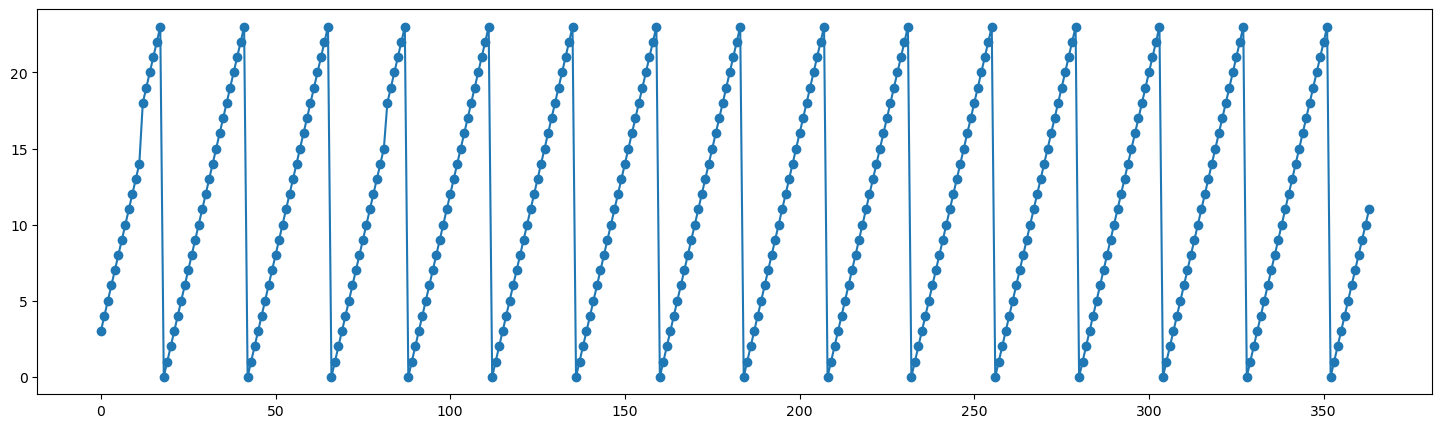

In [21]:
plt.figure(figsize=(18,5))
plt.plot(hours_list, '-o')


In [22]:
hours_list

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 18, 19, 20, 21, 22,
       23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 18, 19, 20,
       21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
        0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
       13, 14, 15, 16, 17

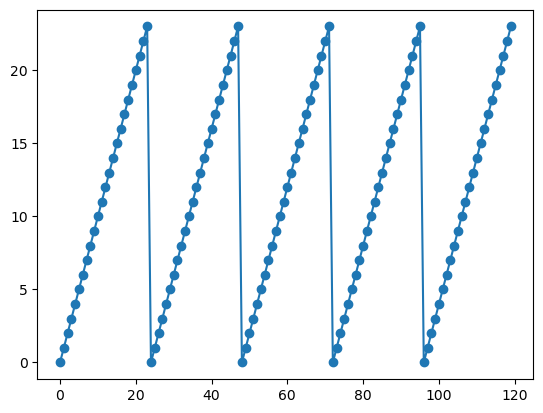

In [23]:
plt.plot(hours_list[136:256], '-o')

In [24]:
saildrone_df_2019_subset = saildrone_df_2019.iloc[136:256]

In [25]:
print("lat:", saildrone_df_2019_subset['lat'].min(), saildrone_df_2019_subset['lat'].max())
print("lon:", saildrone_df_2019_subset['lon'].min(), saildrone_df_2019_subset['lon'].max())

lat: 35.5351487999999 38.163811199999735
lon: -69.5700032 -67.6334848000001


In [26]:
saildrone_df_2019_subset

time        lat        lon  saildrone_number  \
ID                                                                
137 2019-02-05 00:30:00  36.362419 -69.570003              1021   
138 2019-02-05 01:30:00  36.385078 -69.501133              1021   
139 2019-02-05 02:30:00  36.411766 -69.437587              1021   
140 2019-02-05 03:30:00  36.440576 -69.375501              1021   
141 2019-02-05 04:30:00  36.424934 -69.328934              1021   
..                  ...        ...        ...               ...   
252 2019-02-09 19:30:00  37.768470 -67.838035              1021   
253 2019-02-09 20:30:00  37.878518 -67.800077              1021   
254 2019-02-09 21:30:00  37.982112 -67.753754              1021   
255 2019-02-09 22:30:00  38.074662 -67.694566              1021   
256 2019-02-09 23:30:00  38.163811 -67.633485              1021   

     Q_latent_saildrone  Q_sensible_saildrone  wind_speed_saildrone  \
ID                                                                    
137         -289.725967            -78.396245             13.370861   
138         -287.904422            -72.727877             13.888251   
139         -315.980883            -81.344884             14.584905   
140         -300.429087            -87.407883             13.653548   
141         -266.302571            -76.429564             14.744877   
..                  ...                   ...                   ...   
252         -759.356662           -401.812178             14.452571   
253         -777.482628           -415.895702             14.512901   
254         -729.233745           -395.862187             13.580266   
255         -741.178455           -400.388539             13.742340   
256         -720.720643           -391.079621             13.405279   

     Tair_2m_saildrone  SST_saildrone  relative_humidity_saildrone  \
ID                                                                   
137          18.496833      22.134983                    82.367000   
138          18.988667      22.242050                    82.436167   
139          18.886500      22.312500                    82.139000   
140          18.374833      22.332633                    84.286500   
141          19.135000      22.306433                    87.115833   
..                 ...            ...                          ...   
252           7.782000      23.123950                    80.075833   
253           7.259500      23.022617                    78.191833   
254           6.939167      22.991883                    78.561500   
255           6.963500      22.995933                    77.822333   
256           6.811333      22.889617                    77.127000   

     Q_latent_ERA5  Q_lw_ERA5  Q_sensible_ERA5     Q_sw_ERA5   SST_ERA5  \
ID                                                                        
137    -300.255375 -44.451238       -61.406263  5.684342e-14  21.601955   
138    -294.815541 -42.336417       -65.546770  5.684342e-14  21.674972   
139    -278.328309 -40.439215       -68.795088  5.684342e-14  21.781142   
140    -273.541262 -39.796070       -67.325339  5.684342e-14  21.887929   
141    -286.598609 -39.441361       -64.754723  5.684342e-14  21.868106   
..             ...        ...              ...           ...        ...   
252    -756.320584 -89.420364      -392.714889  1.441416e+02  22.240443   
253    -749.337414 -91.893923      -394.033771  6.453361e+01  22.207000   
254    -749.671749 -96.737919      -396.213533  1.515139e+01  21.524102   
255    -706.821655 -94.172034      -374.374284  5.684342e-14  20.523796   
256    -667.268809 -92.766303      -354.022012  5.684342e-14  19.890200   

     Tair_2m_ERA5   sid  
ID                       
137     18.705830  1021  
138     18.682058  1021  
139     18.657378  1021  
140     18.820054  1021  
141     19.017586  1021  
..            ...   ...  
252      7.834835  1021  
253      7.413557  1021  
254      6.913100  1021  
255      6.607040  1021  
256      6.487185  1021 

#### hardcoded saildrone data duration
- start date: 02/05/2019 : 00
- end date: 02/09/2019 : 23

For test data of 2019 find the exact index to compare:
- 35 day skip (35*24 = 840 hrs)
- 840 start index --> 02/05/2019 : 00
- 960 end index --> 02/09/2019 : 23



In [27]:
M1=120

ts = 840

autoreg_pred_840 = np.zeros([M1,len(varlist),Nlat,Nlon])

for k in range(0,M1):

  if (k==0):

    out = (PECstep(net,(psi_test_input_Tr_torch_norm_level1[ts+k,:,0:Nlat,0:Nlon].reshape([1,len(varlist),Nlat,Nlon])).permute(0,2,3,1).cuda()))
    autoreg_pred_840[k,:,:,:] = (out.permute(0,3,1,2)).detach().cpu().numpy()

  else:

    out = (PECstep(net,(torch.from_numpy(autoreg_pred_840[k-1,:,0:Nlat,0:Nlon].reshape([1,len(varlist),Nlat,Nlon])).float()).permute(0,2,3,1).cuda()))
    autoreg_pred_840[k,:,:,:] = (out.permute(0,3,1,2)).detach().cpu().numpy()

In [28]:
autoreg_pred_840.shape

(120, 2, 65, 121)

In [47]:
autoreg_pred_840_denorm = np.zeros_like(autoreg_pred_840)
for i in range(len(varlist)):
    autoreg_pred_840_denorm[:,i,None,:,:] = ((autoreg_pred_840[:,i,None,:,:]*STD_test_level1_np[i] + M_test_level1_np[i]))

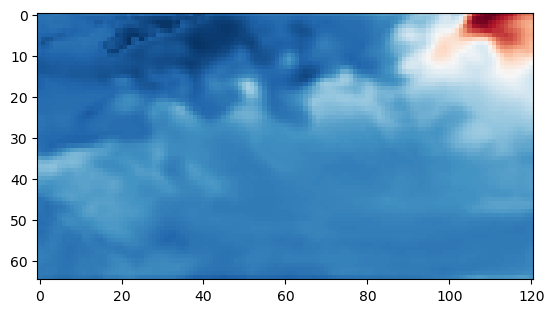

In [48]:
plt.imshow(autoreg_pred_840_denorm[0,1,:,:], cmap='RdBu')

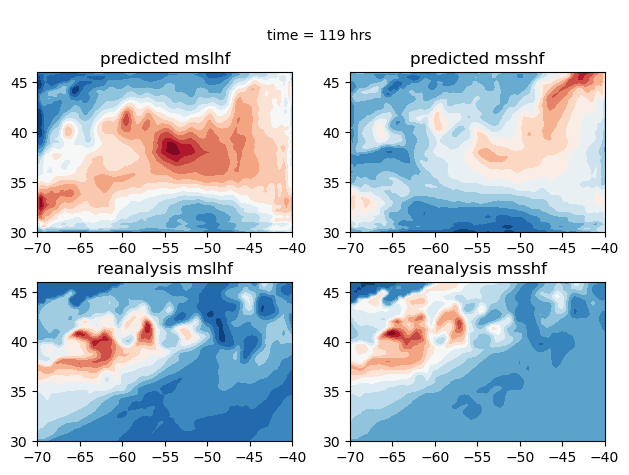

In [49]:
fig, axes = plt.subplots(2,2)
fig.tight_layout(h_pad=2)

camera = Camera(fig)

for t in range(120):

    axes[0][0].contourf(X, Y, autoreg_pred_840_denorm[t,0,:,:], 15, cmap='RdBu');
    axes[0][1].contourf(X, Y, autoreg_pred_840_denorm[t,1,:,:], 15, cmap='RdBu');

    axes[1][0].contourf(X, Y, psi_test_label_Tr[840+t,0,:,:], 15, cmap='RdBu');
    axes[1][1].contourf(X, Y, psi_test_label_Tr[840+t,1,:,:], 15, cmap='RdBu');
    
    axes[0][0].set_title('predicted ' + varlist[0])
    axes[0][1].set_title('predicted ' + varlist[1])
    
    axes[1][0].set_title('reanalysis ' + varlist[0])
    axes[1][1].set_title('reanalysis ' + varlist[1])
    
    fig.suptitle("  ")
    
    axes[0][0].text(0.9, 1.2, 'time = ' + str(t) + ' hrs', transform=axes[0][0].transAxes)
    
    plt.subplots_adjust(top=0.85)
    
    camera.snap()


ani2 = camera.animate()
HTML(ani2.to_html5_video())

In [50]:
saildrone_df_2019_subset

time        lat        lon  saildrone_number  \
ID                                                                
137 2019-02-05 00:30:00  36.362419 -69.570003              1021   
138 2019-02-05 01:30:00  36.385078 -69.501133              1021   
139 2019-02-05 02:30:00  36.411766 -69.437587              1021   
140 2019-02-05 03:30:00  36.440576 -69.375501              1021   
141 2019-02-05 04:30:00  36.424934 -69.328934              1021   
..                  ...        ...        ...               ...   
252 2019-02-09 19:30:00  37.768470 -67.838035              1021   
253 2019-02-09 20:30:00  37.878518 -67.800077              1021   
254 2019-02-09 21:30:00  37.982112 -67.753754              1021   
255 2019-02-09 22:30:00  38.074662 -67.694566              1021   
256 2019-02-09 23:30:00  38.163811 -67.633485              1021   

     Q_latent_saildrone  Q_sensible_saildrone  wind_speed_saildrone  \
ID                                                                    
137         -289.725967            -78.396245             13.370861   
138         -287.904422            -72.727877             13.888251   
139         -315.980883            -81.344884             14.584905   
140         -300.429087            -87.407883             13.653548   
141         -266.302571            -76.429564             14.744877   
..                  ...                   ...                   ...   
252         -759.356662           -401.812178             14.452571   
253         -777.482628           -415.895702             14.512901   
254         -729.233745           -395.862187             13.580266   
255         -741.178455           -400.388539             13.742340   
256         -720.720643           -391.079621             13.405279   

     Tair_2m_saildrone  SST_saildrone  relative_humidity_saildrone  \
ID                                                                   
137          18.496833      22.134983                    82.367000   
138          18.988667      22.242050                    82.436167   
139          18.886500      22.312500                    82.139000   
140          18.374833      22.332633                    84.286500   
141          19.135000      22.306433                    87.115833   
..                 ...            ...                          ...   
252           7.782000      23.123950                    80.075833   
253           7.259500      23.022617                    78.191833   
254           6.939167      22.991883                    78.561500   
255           6.963500      22.995933                    77.822333   
256           6.811333      22.889617                    77.127000   

     Q_latent_ERA5  Q_lw_ERA5  Q_sensible_ERA5     Q_sw_ERA5   SST_ERA5  \
ID                                                                        
137    -300.255375 -44.451238       -61.406263  5.684342e-14  21.601955   
138    -294.815541 -42.336417       -65.546770  5.684342e-14  21.674972   
139    -278.328309 -40.439215       -68.795088  5.684342e-14  21.781142   
140    -273.541262 -39.796070       -67.325339  5.684342e-14  21.887929   
141    -286.598609 -39.441361       -64.754723  5.684342e-14  21.868106   
..             ...        ...              ...           ...        ...   
252    -756.320584 -89.420364      -392.714889  1.441416e+02  22.240443   
253    -749.337414 -91.893923      -394.033771  6.453361e+01  22.207000   
254    -749.671749 -96.737919      -396.213533  1.515139e+01  21.524102   
255    -706.821655 -94.172034      -374.374284  5.684342e-14  20.523796   
256    -667.268809 -92.766303      -354.022012  5.684342e-14  19.890200   

     Tair_2m_ERA5   sid  
ID                       
137     18.705830  1021  
138     18.682058  1021  
139     18.657378  1021  
140     18.820054  1021  
141     19.017586  1021  
..            ...   ...  
252      7.834835  1021  
253      7.413557  1021  
254      6.913100  1021  
255      6.607040  1021  
256      6.487185  1021 

In [51]:
from scipy.interpolate import RegularGridInterpolator

In [52]:
test_interp = RegularGridInterpolator((lat_vals, lon_vals), autoreg_pred_840_denorm[0,1,:,:])

In [53]:
test_interp([36.362419, -69.75])[0]

-56.10106956637948

In [54]:
saildrone_df_2019_subset.iloc[0]

time                           2019-02-05 00:30:00
lat                                      36.362419
lon                                     -69.570003
saildrone_number                              1021
Q_latent_saildrone                     -289.725967
Q_sensible_saildrone                    -78.396245
wind_speed_saildrone                     13.370861
Tair_2m_saildrone                        18.496833
SST_saildrone                            22.134983
relative_humidity_saildrone                 82.367
Q_latent_ERA5                          -300.255375
Q_lw_ERA5                               -44.451238
Q_sensible_ERA5                         -61.406263
Q_sw_ERA5                                      0.0
SST_ERA5                                 21.601955
Tair_2m_ERA5                              18.70583
sid                                           1021
Name: 137, dtype: object

In [145]:
#extract the corresponding values at the drone sites
sail_lat = saildrone_df_2019_subset['lat'].values
sail_lon = saildrone_df_2019_subset['lon'].values

sail_Q_latent_saildrone = saildrone_df_2019_subset['Q_latent_saildrone'].values
sail_Q_latent_ERA5 = saildrone_df_2019_subset['Q_latent_ERA5'].values

sail_Q_sensible_saildrone = saildrone_df_2019_subset['Q_sensible_saildrone'].values




In [60]:
predicted_latent_heat = []
GT_latent_heat = []
for i in range(120):
    pred_temp_interp = RegularGridInterpolator((lat_vals, lon_vals), autoreg_pred_840_denorm[i,0,:,:])
    predicted_latent_heat.append(pred_temp_interp([sail_lat[i], sail_lon[i]])[0])
    
    
    gt_temp_interp = RegularGridInterpolator((lat_vals, lon_vals), psi_test_label_Tr[840+i,0,:,:])
    GT_latent_heat.append(gt_temp_interp([sail_lat[i], sail_lon[i]])[0])
    
    

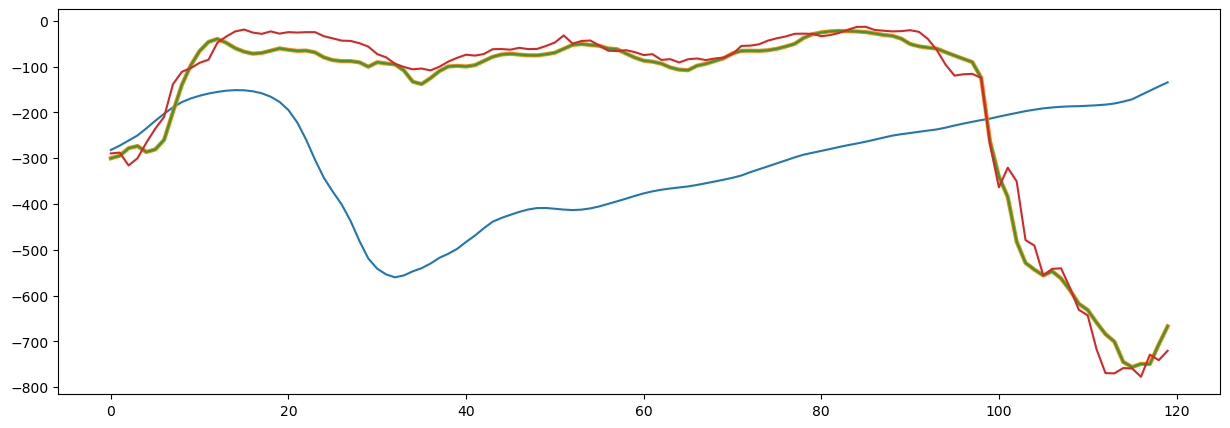

In [67]:
plt.figure(figsize=(15,5))
plt.plot(predicted_latent_heat)
plt.plot(GT_latent_heat, lw=3)
plt.plot(sail_Q_latent_ERA5)
plt.plot(sail_Q_latent_saildrone)

In [70]:
#plug in the salidrone values at the nearest sites
X_flat = X.flatten()
Y_flat = Y.flatten()

In [80]:
from scipy.spatial import KDTree

In [81]:
x1, y1 = np.mgrid[0:5, 2:8]

In [83]:
y1

array([[2, 3, 4, 5, 6, 7],
       [2, 3, 4, 5, 6, 7],
       [2, 3, 4, 5, 6, 7],
       [2, 3, 4, 5, 6, 7],
       [2, 3, 4, 5, 6, 7]])

In [86]:
gridpoints_array = np.c_[Y_flat, X_flat]

46.0

In [89]:
tree = KDTree(gridpoints_array)

In [116]:
iii = 50

In [117]:
print(sail_lat[iii], sail_lon[iii])

35.560614399999984 -68.9973056


In [146]:
def get_nn_indexlist(iii):
    dis, id = tree.query([[sail_lat[iii], sail_lon[iii]]], k=4)
    y_index_list = []
    x_index_list = []
    for i in id[0]:
        # print(i)
        # print(gridpoints_array[i])
        lat_t = gridpoints_array[i][0]
        lon_t = gridpoints_array[i][1]
        y_index = list(lat_vals).index(lat_t)
        x_index = list(lon_vals).index(lon_t)
        y_index_list.append(y_index)
        x_index_list.append(x_index)
        # print(y_index, x_index)
        # print(psi_test_label_Tr[0,0,y_index,x_index])
    return y_index_list, x_index_list, 
    

In [138]:
get_nn_indexlist(53)

([42, 41, 42, 42], [4, 4, 3, 5])

[[ 36.25 -69.5 ]
 [ 36.5  -69.5 ]
 [ 36.25 -69.75]
 [ 36.5  -69.75]]


In [155]:
M1=120

ts = 840

autoreg_pred_840_base = np.zeros([M1,len(varlist),Nlat,Nlon])
autoreg_pred_840_updated = np.zeros([M1,len(varlist),Nlat,Nlon])

for k in range(0,M1):
  
  yindex_list, xindex_list = get_nn_indexlist(k)
  
  sail_lh_value = (sail_Q_latent_saildrone[k]-M_test_level1_np[0])/STD_test_level1_np[0]
  sail_sh_value = (sail_Q_sensible_saildrone[k]-M_test_level1_np[1])/STD_test_level1_np[1]
  

  if (k==0):

    out = (PECstep(net,(psi_test_input_Tr_torch_norm_level1[ts+k,:,0:Nlat,0:Nlon].reshape([1,len(varlist),Nlat,Nlon])).permute(0,2,3,1).cuda()))
    autoreg_pred_840_base[k,:,:,:] = (out.permute(0,3,1,2)).detach().cpu().numpy()
    autoreg_pred_840_updated[k,:,:,:] = np.copy(autoreg_pred_840_base[k,:,:,:])
    for i in range(4):
      autoreg_pred_840_updated[k,0,yindex_list[i],xindex_list[i]] = sail_lh_value
      autoreg_pred_840_updated[k,1,yindex_list[i],xindex_list[i]] = sail_sh_value
    
    

  else:
    
    out = (PECstep(net,(torch.from_numpy(autoreg_pred_840_updated[k-1,:,0:Nlat,0:Nlon].reshape([1,len(varlist),Nlat,Nlon])).float()).permute(0,2,3,1).cuda()))
    autoreg_pred_840_base[k,:,:,:] = (out.permute(0,3,1,2)).detach().cpu().numpy()
    autoreg_pred_840_updated[k,:,:,:] = np.copy(autoreg_pred_840_base[k,:,:,:])
    for i in range(4):
      autoreg_pred_840_updated[k,0,yindex_list[i],xindex_list[i]] = sail_lh_value
      autoreg_pred_840_updated[k,1,yindex_list[i],xindex_list[i]] = sail_sh_value
    
    
    
    
    
    
    

-133.30542

In [156]:
autoreg_pred_840_base_denorm = np.zeros_like(autoreg_pred_840_base)
autoreg_pred_840_updated_denorm = np.zeros_like(autoreg_pred_840_updated)
for i in range(len(varlist)):
    autoreg_pred_840_base_denorm[:,i,None,:,:] = ((autoreg_pred_840_base[:,i,None,:,:]*STD_test_level1_np[i] + M_test_level1_np[i]))
    autoreg_pred_840_updated_denorm[:,i,None,:,:] = ((autoreg_pred_840_updated[:,i,None,:,:]*STD_test_level1_np[i] + M_test_level1_np[i]))

In [159]:
predicted_base_latent_heat = []
predicted_updated_latent_heat = []
for i in range(120):
    pred_base_temp_interp = RegularGridInterpolator((lat_vals, lon_vals), autoreg_pred_840_base_denorm[i,0,:,:])
    predicted_base_latent_heat.append(pred_base_temp_interp([sail_lat[i], sail_lon[i]])[0])
    
    
    pred_updated_temp_interp = RegularGridInterpolator((lat_vals, lon_vals), autoreg_pred_840_updated_denorm[i,0,:,:])
    predicted_updated_latent_heat.append(pred_updated_temp_interp([sail_lat[i], sail_lon[i]])[0])

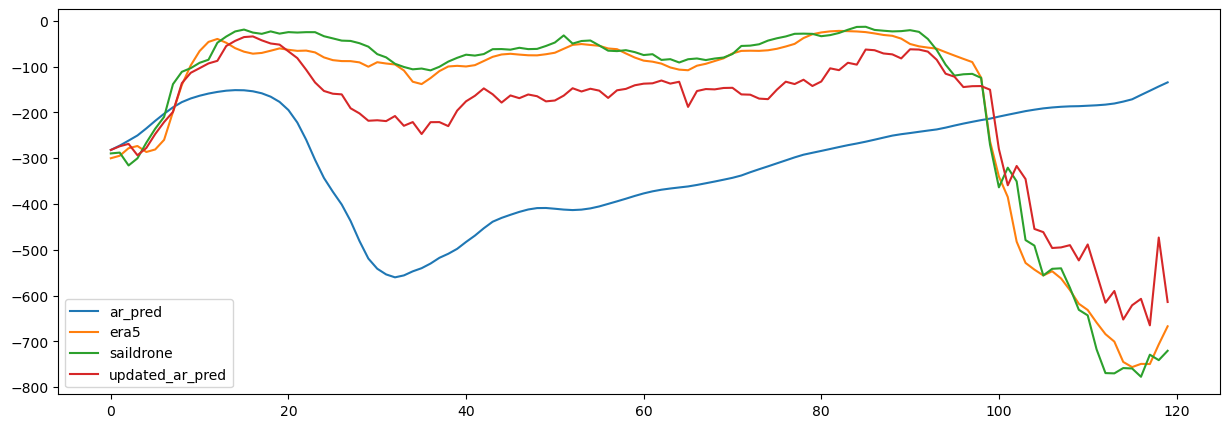

In [179]:
plt.figure(figsize=(15,5))
plt.plot(predicted_latent_heat, label="ar_pred")
plt.plot(GT_latent_heat, label="era5")
# plt.plot(sail_Q_latent_ERA5)
plt.plot(sail_Q_latent_saildrone, label="saildrone")
plt.plot(predicted_base_latent_heat, label="updated_ar_pred")
# plt.plot(predicted_updated_latent_heat, label="updated1_ar_pred")
plt.legend()

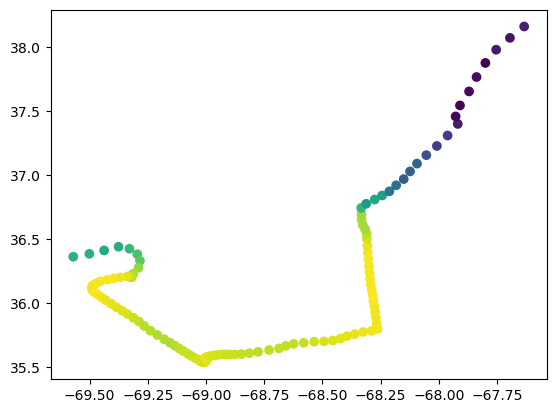

In [174]:
plt.scatter(saildrone_df_2019_subset['lon'], saildrone_df_2019_subset['lat'], c=sail_Q_latent_saildrone)

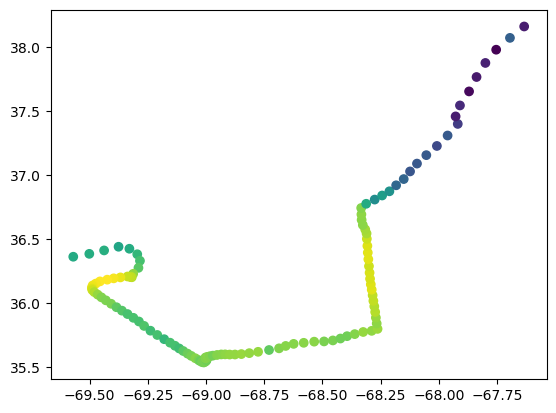

In [175]:
plt.scatter(saildrone_df_2019_subset['lon'], saildrone_df_2019_subset['lat'], c=predicted_base_latent_heat)

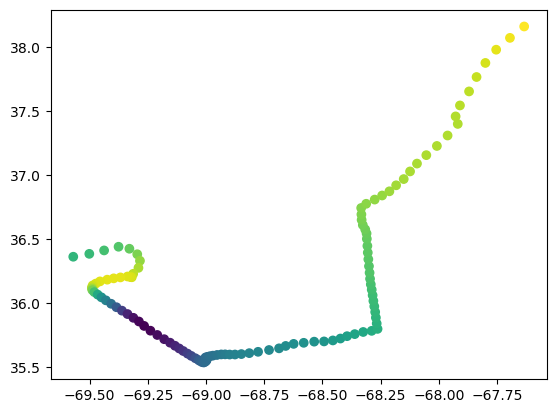

In [176]:
plt.scatter(saildrone_df_2019_subset['lon'], saildrone_df_2019_subset['lat'], c=predicted_latent_heat)

In [30]:
def get_lat_lon():
    FF=nc.Dataset('/data/NASA_DTAS_datastore/MSSHF_large_domain/MSSHFdeg_0252019.nc')
    lat_vals = np.asarray(FF['latitude'])
    lon_vals = np.asarray(FF['longitude'])


    
    
    return lat_vals, lon_vals

In [31]:
from matplotlib import animation
from IPython.display import HTML
from celluloid import Camera

In [32]:
lat_vals, lon_vals = get_lat_lon()

In [33]:
print("full grid max min")
print("lat:", min(lat_vals), max(lat_vals))
print("lon:", min(lon_vals), max(lon_vals))


full grid max min
lat: 30.0 46.0
lon: -70.0 -40.0


In [34]:
print("lat:", saildrone_df_2019_subset['lat'].min(), saildrone_df_2019_subset['lat'].max())
print("lon:", saildrone_df_2019_subset['lon'].min(), saildrone_df_2019_subset['lon'].max())

lat: 35.5351487999999 38.163811199999735
lon: -69.5700032 -67.6334848000001


We can take lat [30 to 40] and lon [-70 to -60]

In [35]:
X, Y = np.meshgrid(lon_vals, lat_vals)



In [36]:
list(lat_vals).index(35.75)

41

In [37]:
X.shape

(65, 121)

In [38]:
psi_test_label_Tr_torch.shape

torch.Size([8759, 2, 65, 121])

In [39]:
psi_test_label_Tr_torch[840:841,0,:,:].min()

tensor(-560.0516)

In [135]:
def find_index(lon_x,lat_y):
    xi=np.searchsorted(lon_vals,lon_x)
    yi=np.searchsorted(lat_vals[::-1],lat_y)
    return lon_vals[xi],lat_vals[yi]

In [126]:
np.linspace(15,30,61)

array([15.  , 15.25, 15.5 , 15.75, 16.  , 16.25, 16.5 , 16.75, 17.  ,
       17.25, 17.5 , 17.75, 18.  , 18.25, 18.5 , 18.75, 19.  , 19.25,
       19.5 , 19.75, 20.  , 20.25, 20.5 , 20.75, 21.  , 21.25, 21.5 ,
       21.75, 22.  , 22.25, 22.5 , 22.75, 23.  , 23.25, 23.5 , 23.75,
       24.  , 24.25, 24.5 , 24.75, 25.  , 25.25, 25.5 , 25.75, 26.  ,
       26.25, 26.5 , 26.75, 27.  , 27.25, 27.5 , 27.75, 28.  , 28.25,
       28.5 , 28.75, 29.  , 29.25, 29.5 , 29.75, 30.  ])

In [136]:
find_index(-69.570003,36.362419)

(-69.5, 39.5)

In [134]:
Y

array([[46.  , 46.  , 46.  , ..., 46.  , 46.  , 46.  ],
       [45.75, 45.75, 45.75, ..., 45.75, 45.75, 45.75],
       [45.5 , 45.5 , 45.5 , ..., 45.5 , 45.5 , 45.5 ],
       ...,
       [30.5 , 30.5 , 30.5 , ..., 30.5 , 30.5 , 30.5 ],
       [30.25, 30.25, 30.25, ..., 30.25, 30.25, 30.25],
       [30.  , 30.  , 30.  , ..., 30.  , 30.  , 30.  ]], dtype=float32)

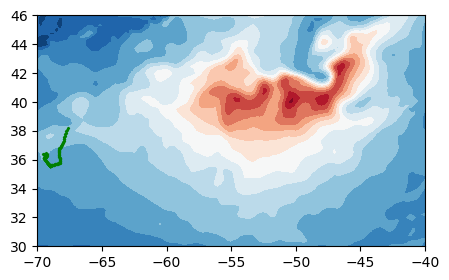

In [40]:
plt.figure(figsize=(5,3))
plt.contourf(X, Y, autoreg_pred[0,1,:,:], 15, cmap='RdBu', zorder=0)
plt.scatter(saildrone_df_2019_subset['lon'], saildrone_df_2019_subset['lat'],marker = 'x', s = 2, color = 'g', zorder=1)
plt.show()

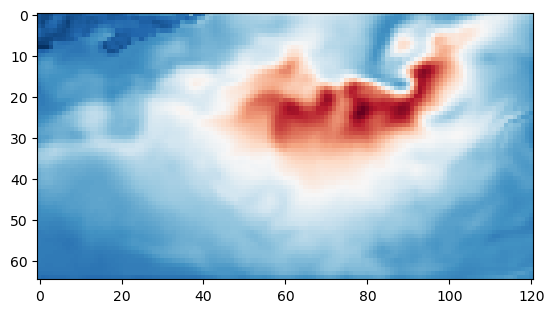

In [111]:
plt.imshow(autoreg_pred[0,1,:,:], cmap='RdBu')

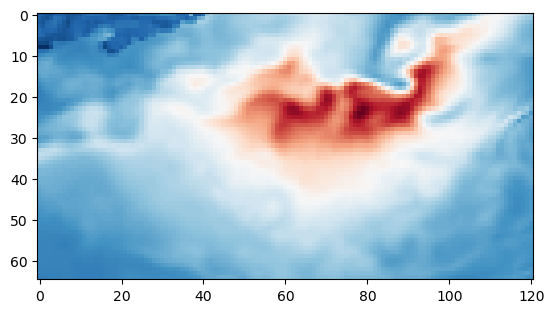

In [19]:
plt.imshow(psi_test_label_Tr[0,1,:,:], cmap='RdBu')

In [20]:
psi_test_label_Tr[0,1,:,:].mean()

-97.76017

In [21]:
autoreg_pred[0,1,:,:].mean()

-1.1616772999666105

In [22]:
autoreg_pred_denorm[0,1,:,:].mean()

NameError: name 'autoreg_pred_denorm' is not defined

In [48]:
print(M_test_level1)
print(STD_test_level1)

tensor([-133.3054,  -27.5596])
tensor([130.9617,  60.5951])


In [41]:
M_test_level1_np = M_test_level1.detach().cpu().numpy()
STD_test_level1_np = STD_test_level1.detach().cpu().numpy()

In [42]:
psi_test_label_Tr_torch_norm_level1 = torch.zeros_like(psi_test_label_Tr_torch)

In [43]:
autoreg_pred_denorm = np.zeros_like(autoreg_pred)

In [44]:
psi_test_input_Tr_torch_norm_level1.shape

torch.Size([8759, 2, 65, 121])

In [45]:
for i in range(len(varlist)):
    autoreg_pred_denorm[:,i,None,:,:] = ((autoreg_pred[:,i,None,:,:]*STD_test_level1_np[i] + M_test_level1_np[i]))

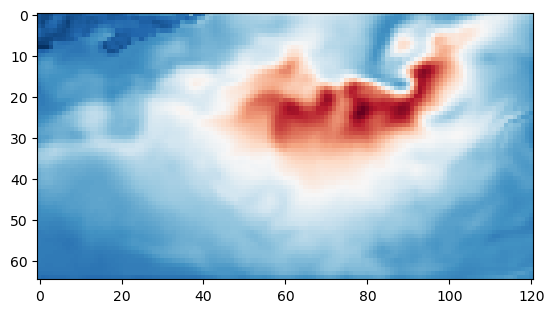

In [46]:
plt.imshow(autoreg_pred_denorm[0,1,:,:], cmap='RdBu')

In [35]:
autoreg_pred_denorm[0,1,:,:].shape

(65, 121)

In [38]:
print(lat_vals.shape,lon_vals.shape)

(65,) (121,)


In [34]:
from scipy.interpolate import RegularGridInterpolator

In [39]:
test_interp = RegularGridInterpolator((lat_vals, lon_vals), autoreg_pred_denorm[0,1,:,:])

In [40]:
test_interp

In [43]:
pts = np.array([[45.75, -69.75]])

In [50]:
test_interp([45.75, -69.75])[0]

34.613410466296045

In [41]:
lat_vals

array([46.  , 45.75, 45.5 , 45.25, 45.  , 44.75, 44.5 , 44.25, 44.  ,
       43.75, 43.5 , 43.25, 43.  , 42.75, 42.5 , 42.25, 42.  , 41.75,
       41.5 , 41.25, 41.  , 40.75, 40.5 , 40.25, 40.  , 39.75, 39.5 ,
       39.25, 39.  , 38.75, 38.5 , 38.25, 38.  , 37.75, 37.5 , 37.25,
       37.  , 36.75, 36.5 , 36.25, 36.  , 35.75, 35.5 , 35.25, 35.  ,
       34.75, 34.5 , 34.25, 34.  , 33.75, 33.5 , 33.25, 33.  , 32.75,
       32.5 , 32.25, 32.  , 31.75, 31.5 , 31.25, 31.  , 30.75, 30.5 ,
       30.25, 30.  ], dtype=float32)

In [42]:
lon_vals

array([-70.  , -69.75, -69.5 , -69.25, -69.  , -68.75, -68.5 , -68.25,
       -68.  , -67.75, -67.5 , -67.25, -67.  , -66.75, -66.5 , -66.25,
       -66.  , -65.75, -65.5 , -65.25, -65.  , -64.75, -64.5 , -64.25,
       -64.  , -63.75, -63.5 , -63.25, -63.  , -62.75, -62.5 , -62.25,
       -62.  , -61.75, -61.5 , -61.25, -61.  , -60.75, -60.5 , -60.25,
       -60.  , -59.75, -59.5 , -59.25, -59.  , -58.75, -58.5 , -58.25,
       -58.  , -57.75, -57.5 , -57.25, -57.  , -56.75, -56.5 , -56.25,
       -56.  , -55.75, -55.5 , -55.25, -55.  , -54.75, -54.5 , -54.25,
       -54.  , -53.75, -53.5 , -53.25, -53.  , -52.75, -52.5 , -52.25,
       -52.  , -51.75, -51.5 , -51.25, -51.  , -50.75, -50.5 , -50.25,
       -50.  , -49.75, -49.5 , -49.25, -49.  , -48.75, -48.5 , -48.25,
       -48.  , -47.75, -47.5 , -47.25, -47.  , -46.75, -46.5 , -46.25,
       -46.  , -45.75, -45.5 , -45.25, -45.  , -44.75, -44.5 , -44.25,
       -44.  , -43.75, -43.5 , -43.25, -43.  , -42.75, -42.5 , -42.25,
      

In [60]:
test_interp_field = np.zeros_like(X)
for y in range(65):
    for x in range(121):
        test_interp_field[y][x] = test_interp([Y[y][x], X[y][x]])[0]

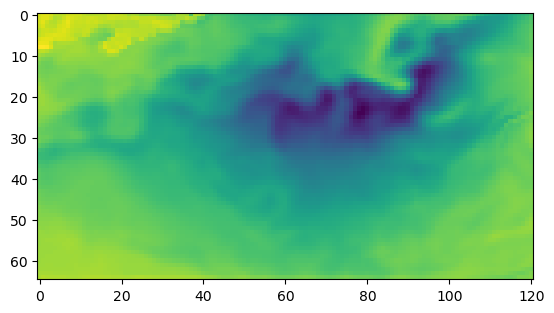

In [61]:
plt.imshow(test_interp_field)

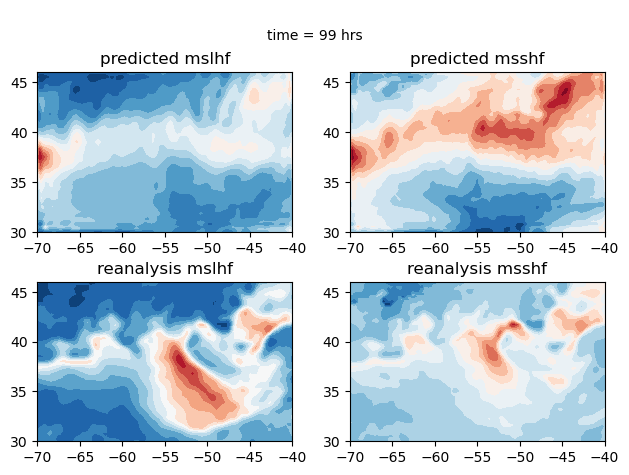

In [28]:
fig, axes = plt.subplots(2,2)
fig.tight_layout(h_pad=2)

camera = Camera(fig)

for t in range(100):

    axes[0][0].contourf(X, Y, autoreg_pred[t,0,:,:], 15, cmap='RdBu');
    axes[0][1].contourf(X, Y, autoreg_pred[t,1,:,:], 15, cmap='RdBu');

    axes[1][0].contourf(X, Y, psi_test_label_Tr[t,0,:,:], 15, cmap='RdBu');
    axes[1][1].contourf(X, Y, psi_test_label_Tr[t,1,:,:], 15, cmap='RdBu');
    
    axes[0][0].set_title('predicted ' + varlist[0])
    axes[0][1].set_title('predicted ' + varlist[1])
    
    axes[1][0].set_title('reanalysis ' + varlist[0])
    axes[1][1].set_title('reanalysis ' + varlist[1])
    
    fig.suptitle("  ")
    
    axes[0][0].text(0.9, 1.2, 'time = ' + str(t) + ' hrs', transform=axes[0][0].transAxes)
    
    plt.subplots_adjust(top=0.85)
    
    camera.snap()


ani2 = camera.animate()
HTML(ani2.to_html5_video())

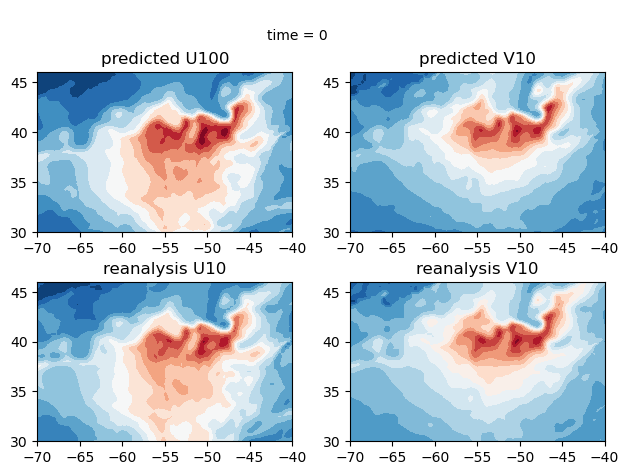

In [29]:
fig, axes = plt.subplots(2,2)
fig.tight_layout(h_pad=2)

# camera = Camera(fig)

for t in range(1):

    axes[0][0].contourf(X, Y, autoreg_pred[t,0,:,:], 15, cmap='RdBu');
    axes[0][1].contourf(X, Y, autoreg_pred[t,1,:,:], 15, cmap='RdBu');

    axes[1][0].contourf(X, Y, psi_test_label_Tr[t,0,:,:], 15, cmap='RdBu');
    axes[1][1].contourf(X, Y, psi_test_label_Tr[t,1,:,:], 15, cmap='RdBu');
    
    axes[0][0].set_title('predicted U10' + str(t))
    axes[0][1].set_title('predicted V10')
    
    axes[1][0].set_title('reanalysis U10')
    axes[1][1].set_title('reanalysis V10')
    
    fig.suptitle("  ")
    
    axes[0][0].text(0.9, 1.2, 'time = ' + str(t), transform=axes[0][0].transAxes)
    
    plt.subplots_adjust(top=0.85)
    
    # camera.snap()


# ani2 = camera.animate()
# HTML(ani2.to_html5_video())

#### Test spectral loss for multivariaye cases

In [30]:
def spectral_loss_mv(output, target,wavenum_init,wavenum_init_ydir,lamda_reg,ocean_grid):

 loss1 = torch.sum((output-target)**2)/ocean_grid
 channel_len = output.shape[-1]

 # out_fft = torch.mean(torch.abs(torch.fft.rfft(output[:,:,:,0],dim=2)),dim=1)
 # target_fft = torch.mean(torch.abs(torch.fft.rfft(target[:,:,:,0],dim=2)),dim=1)
 
#  out_fft_ydir_list = []
#  target_fft_ydir_list = []
 loss2_ydir_list = []
 
 for v in range(channel_len):
    out_fft_ydir = torch.mean(torch.abs(torch.fft.rfft(output[:,:,:,v],dim=1)),dim=2)
    target_fft_ydir = torch.mean(torch.abs(torch.fft.rfft(target[:,:,:,v],dim=1)),dim=2)
    
    loss2_ydir = torch.mean(torch.abs(out_fft_ydir[:,wavenum_init_ydir:]-target_fft_ydir[:,wavenum_init_ydir:]))
    
    # out_fft_ydir_list.append(out_fft_ydir)
    # target_fft_ydir_list.append(target_fft_ydir)
    loss2_ydir_list.append(loss2_ydir)
    
 loss2_ydir_all_channel = torch.mean(torch.FloatTensor(loss2_ydir_list))
#  print(output.shape, out_fft_ydir.shape) 
 
#  print(target.shape, target_fft_ydir.shape)


 # loss2 = torch.mean(torch.abs(out_fft[:,wavenum_init:]-target_fft[:,wavenum_init:]))
 

 loss = ((1-lamda_reg)*loss1 + lamda_reg**loss2_ydir_all_channel)

 return loss

In [31]:
wavenum_init_ydir

0

In [32]:
output_val = PECstep(net,(psi_test_input_Tr_torch_norm_level1[0:1,:,0:Nlat,0:Nlon].reshape([1,len(varlist),Nlat,Nlon])).permute(0,2,3,1))


In [33]:
output_val.shape

torch.Size([1, 65, 121, 2])

In [34]:
ocean_grid = psi_test_label_Tr.shape[2] * psi_test_label_Tr.shape[3] 

In [35]:
ocean_grid

7865

In [36]:
val_loss = spectral_loss_mv(output_val, (psi_test_label_Tr_torch_norm_level1[0:1,:,0:Nlat,0:Nlon].reshape([1,len(varlist),Nlat,Nlon])).permute(0,2,3,1).cuda(),wavenum_init,wavenum_init_ydir,lamda_reg,(torch.tensor(ocean_grid)).cuda())

In [37]:
val_loss

tensor(0.5476, device='cuda:0', grad_fn=<AddBackward0>)

In [38]:
out_fft = out_fft.detach().cpu().numpy()
target_fft = target_fft.detach().cpu().numpy()

NameError: name 'out_fft' is not defined

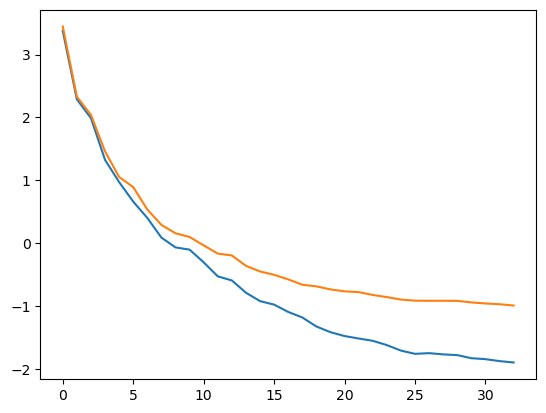

In [108]:
plt.plot(np.log(out_fft[0]))
plt.plot(np.log(target_fft[0]))